In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from transformers import BertTokenizer
from transformers import BertModel
import torch
from sklearn.cluster import KMeans
from umap import UMAP
import numpy as np
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading & Text Cleaning
Cleans text:
  Removes URLs,
   mentions,
   emojis,
   special characters
  Translates non-English comments
  Emojis → textual equivalents
  Lemmatization
  Stopword removal

In [5]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob  # For translation

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def strip_bytes(s):
    if isinstance(s, str) and s.startswith("b'"):
        return s[2:-1]
    return s

def translate_text(text):
    try:
        blob = TextBlob(text)
        return str(blob.translate(from_lang='en', to='en'))
    except:
        return text

def clean_text(text):
    text = re.sub(r"http\S+|@\S+|[^A-Za-z\s]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.lower().split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

df = pd.read_csv('/content/War.csv')
df['tweets'] = df['tweets'].astype(str).apply(strip_bytes).apply(translate_text)
df['clean_text'] = df['tweets'].apply(clean_text)

## Unsupervised Topic Modeling Using BERT + UMAP + Clustering
BERT embeddings
Applies UMAP for dimensionality reduction
Performs KMeans clustering to find topics like:
Geopolitics, Civilian Impact, Economy, etc.

In [6]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# def get_bert_embeddings(texts):
#     encoded = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
#     with torch.no_grad():
#         outputs = bert_model(**encoded)
#     return outputs.last_hidden_state[:, 0, :].numpy()  # Use CLS token

# texts = df['clean_text'].tolist()
# embeddings = get_bert_embeddings(texts)

# # Reduce dimensions
# umap_embeddings = UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(embeddings)

# # Cluster
# kmeans = KMeans(n_clusters=10, random_state=0).fit(umap_embeddings)
# df['topic_label'] = kmeans.labels_
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from umap import UMAP
import numpy as np
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embeddings(texts, batch_size=16):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=128).to(device)

        with torch.no_grad():
            outputs = bert_model(**encoded)

        # Move result back to CPU and convert to NumPy
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(embeddings)

        print(f"Processed batch {i // batch_size + 1} / {(len(texts) // batch_size) + 1}")

    return np.vstack(all_embeddings)

# Assume df['clean_text'] is already defined
texts = df['clean_text'].tolist()

# Check if embeddings are already saved
if os.path.exists("bert_embeddings.npy"):
    print("Loading saved BERT embeddings...")
    embeddings = np.load("bert_embeddings.npy")
else:
    print("Generating BERT embeddings...")
    embeddings = get_bert_embeddings(texts)
    np.save("bert_embeddings.npy", embeddings)
    print("Embeddings saved.")

# Check if UMAP is already done
if os.path.exists("umap_embeddings.npy"):
    print("Loading saved UMAP embeddings...")
    umap_embeddings = np.load("umap_embeddings.npy")
else:
    print("Reducing dimensions with UMAP...")
    umap_embeddings = UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(embeddings)
    np.save("umap_embeddings.npy", umap_embeddings)
    print("UMAP embeddings saved.")

# Clustering
if os.path.exists("kmeans_labels.npy"):
    print("Loading saved KMeans labels...")
    kmeans_labels = np.load("kmeans_labels.npy")
else:
    print("Clustering with KMeans...")
    kmeans = KMeans(n_clusters=10, random_state=0, n_init=10).fit(umap_embeddings)
    kmeans_labels = kmeans.labels_
    np.save("kmeans_labels.npy", kmeans_labels)
    print("KMeans labels saved.")

# Add topic labels to DataFrame
df['topic_label'] = kmeans_labels
print("##Done! Topic labels added to DataFrame.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Generating BERT embeddings...
Processed batch 1 / 1122
Processed batch 2 / 1122
Processed batch 3 / 1122
Processed batch 4 / 1122
Processed batch 5 / 1122
Processed batch 6 / 1122
Processed batch 7 / 1122
Processed batch 8 / 1122
Processed batch 9 / 1122
Processed batch 10 / 1122
Processed batch 11 / 1122
Processed batch 12 / 1122
Processed batch 13 / 1122
Processed batch 14 / 1122
Processed batch 15 / 1122
Processed batch 16 / 1122
Processed batch 17 / 1122
Processed batch 18 / 1122
Processed batch 19 / 1122
Processed batch 20 / 1122
Processed batch 21 / 1122
Processed batch 22 / 1122
Processed batch 23 / 1122
Processed batch 24 / 1122
Processed batch 25 / 1122
Processed batch 26 / 1122
Processed batch 27 / 1122
Processed batch 28 / 1122
Processed batch 29 / 1122
Processed batch 30 / 1122
Processed batch 31 / 1122
Processed batch 32 / 1122
Processed batch 33 / 1122
Processed batch 34 / 1122
Processed batch 35 / 1122
Processed batch 36 / 1122
Processed batch 37 / 1122
Processed batch 3

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP embeddings saved.
Clustering with KMeans...
KMeans labels saved.
##Done! Topic labels added to DataFrame.


## Sentiment Labeling Using VADER

In [8]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_text'].apply(get_sentiment)

## Build Hybrid BERT-CNN Model With Topic Embedding

In [10]:


class BERTCNNClassifier(nn.Module):
    def __init__(self, num_topics=10, num_classes=3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.conv1 = nn.Conv1d(768, 128, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.topic_embedding = nn.Embedding(num_topics, 128)
        self.fc1 = nn.Linear(128 + 128, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, topic_ids):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = bert_output.last_hidden_state.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(2)

        topic_emb = self.topic_embedding(topic_ids)

        combined = torch.cat([x, topic_emb], dim=1)
        x = self.dropout(combined)
        x = self.fc1(x)
        return self.fc2(x)

## Tokenize and Prepare DataLoader

In [11]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch

# Initialize LabelEncoder
le = LabelEncoder()

encoded = tokenizer.batch_encode_plus(
    df['clean_text'].tolist(),
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded['input_ids']
attention_masks = encoded['attention_mask']
labels = torch.tensor(le.fit_transform(df['sentiment']))
topics = torch.tensor(df['topic_label'].values)

dataset = TensorDataset(input_ids, attention_masks, labels, topics)
train_size = int(0.8 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset)-train_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

## Train the Model

In [12]:
model = BERTCNNClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids_batch, mask_batch, label_batch, topic_batch = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids_batch, mask_batch, topic_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 377.9142
Epoch 2, Loss: 117.3781
Epoch 3, Loss: 62.9192
Epoch 4, Loss: 41.4123
Epoch 5, Loss: 26.3895


## Evaluate Performance

In [13]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids_batch, mask_batch, label_batch, topic_batch = [b.to(device) for b in batch]
        outputs = model(input_ids_batch, mask_batch, topic_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label_batch.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.97      0.97      0.97      1381
     neutral       0.96      0.95      0.96      1000
    positive       0.95      0.97      0.96      1210

    accuracy                           0.96      3591
   macro avg       0.96      0.96      0.96      3591
weighted avg       0.96      0.96      0.96      3591



## Visualization

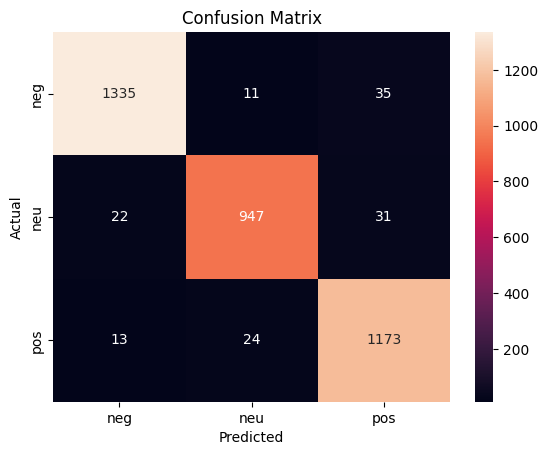

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()